In [1]:
import skimage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import ndimage
from skimage.data import astronaut, coffee, cat, rocket, binary_blobs, brain, clock

In [43]:
images = [astronaut(), coffee(), cat(), clock(), rocket()]

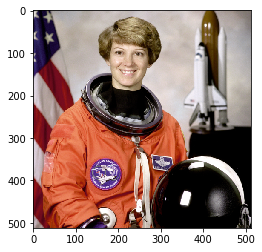

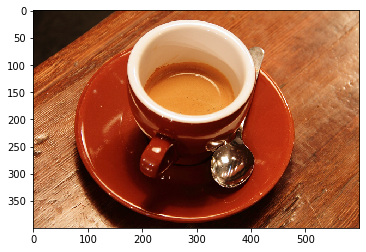

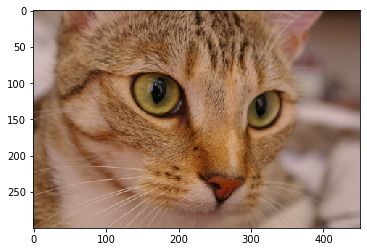

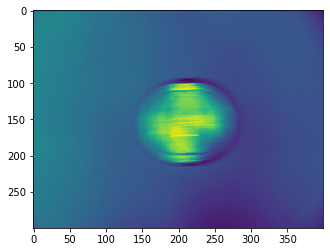

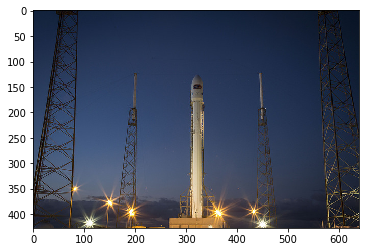

In [44]:
for img in images:
    plt.imshow(img)
    plt.show()

Papers:
* [Image Filtering Algorithms and Techniques: a review](https://www.researchgate.net/profile/Gaurav-Gupta-53/publication/325681876_Image_Filtering_Algorithms_and_Techniques_A_Review/links/5b1e1ab0aca272021cf585c9/Image-Filtering-Algorithms-and-Techniques-A-Review.pdf)

* [Analysis of color image filtering methods](https://www.researchgate.net/profile/Ziad-Alqadi/publication/319815286_Analysis_of_Color_Image_Filtering_Methods/links/59bcfa52aca272aff2d9d86b/Analysis-of-Color-Image-Filtering-Methods.pdf)

* [Digital Image Filtering Techniques- A survey](https://www.researchgate.net/publication/324985754_Digital_Image_Filtering_Techniques-_A_survey)

In [24]:
def add_salt_pepper(image, prob):
    """
    Add salt and pepper noise to a given image.
    
    Parameters
    ----------
    image : numpy.array
        Image to add noise to.
    prob: float
        Probability of the noise.
    
    References
    ----------
    Taken from:
    https://gist.github.com/lucaswiman/1e877a164a69f78694f845eab45c381a
    """
    output = image.copy()
    
    if len(image.shape) == 2:
        black = 0
        white = 255            
    else:
        colorspace = image.shape[2]
        if colorspace == 3:  # RGB
            black = np.array([0, 0, 0], dtype='uint8')
            white = np.array([255, 255, 255], dtype='uint8')
        else:  # RGBA
            black = np.array([0, 0, 0, 255], dtype='uint8')
            white = np.array([255, 255, 255, 255], dtype='uint8')
    
    probs = np.random.random(image.shape[:2])
    output[probs < (prob / 2)] = black
    output[probs > 1 - (prob / 2)] = white
    
    return output


def add_noise(img, mean=0, std=1, cast=True):
    """Add gaussian noise to a given image to create a noisy
    image.
    
    Parameters
    ----------
    img : numpy.array
        Image to add noise to.
    mean : int or float
        Mean of the gaussian noise.
    std : int or float
        Standard deviation of the gaussian noise.
    
    References
    ----------
    .. [1] StackOverflow - Why does adding Gaussian noise to image give white screen?
       https://stackoverflow.com/questions/50641860/why-does-adding-gaussian-noise-to-image-give-white-screen
    """
    noisy_img = np.clip(img + np.random.normal(mean, std, img.shape), 0, 255)
    
    if cast:
        noisy_img = noisy_img.astype('uint8') # cast to unsigned integer. See references
    
    return noisy_img

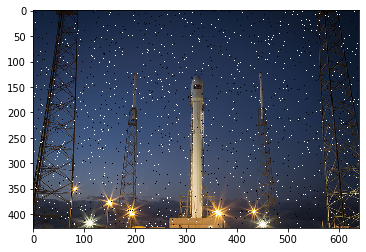

In [45]:
sp = add_salt_pepper(image=img, prob=0.02)
plt.imshow(sp)

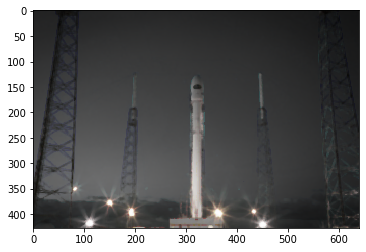

In [46]:
plt.imshow(ndimage.median_filter(sp, size=5))

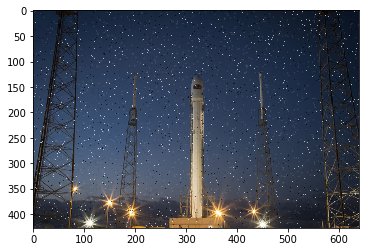

In [47]:
plt.imshow(ndimage.gaussian_filter(sp, 0.5))

In [ ]:
# filters
# https://scikit-image.org/docs/dev/api/skimage.filters.html

# Morphologic operations
# https://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html